# Week 8 - Linear Disciminant Analysis and Optimization

* FDA (2 classes)
    * Compute the class means (in PCA space)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection vector $\mathbf{w}$
    * Compute and plot the 1D projection of the data
    * Compute the class separation of the projected values
* LDA (3 classes)
    * Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
    * Compute the projection matrix $\mathbf{W}$
    * Compute and plot the 2D projection of the data
    * Compute the 2D LDA projection of the original 64D data 
* Constrained Optimization
    * Reformulate the problem as a maximization problem
    * Write out the Lagrangian function
    * Compute the gradients with respects to $x_1, x_2$, Lagrange multiplier $\lambda$ and the KKT multiplier $\mu$
    * Compute the optimum

In [60]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits, make_swiss_roll
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns; sns.set(); sns.set_palette('bright')

## Data
As usual, we'll be working with a dataset of handwritten digits. 
Let visualise some examples.

In [61]:
# We're using a subset of two classes for now
digits = load_digits(n_class=2)

In [62]:
# Handy plotting functions

def plot_examples():
    show_num = 4
    _, axes = plt.subplots(1, show_num)
    images_and_labels = list(zip(digits.images, digits.target))
    for ax, (image, label) in zip(axes[:], images_and_labels[:show_num]):
        ax.set_axis_off()
        ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
        ax.set_title('Label: %i' % label)

def plot_scatter(data, target, alpha=0.5, legend=True,w=None):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')

    if w is not None:
        # Define the range of x values based on the scatter plot data
        x_values = np.linspace(np.min(data[:, 0]), np.max(data[:, 0]), 100)
        
        # Calculate corresponding y values based on the line equation: w0 + w1*x1 + w2*x2 = 0 => x2 = -(w0 + w1*x1) / w2
        y_values = w[1] * x_values + w[0]

        # Plot the line
        plt.plot(x_values, y_values, color='red', label='Decision boundary')
    #plt.show()
    
def plot_scatter3d(data, targets, view_point=(25, 45), alpha=0.5, legend=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(data[:,0], data[:,1], data[:,2], c=targets, cmap="rainbow", alpha=alpha)
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    ax.view_init(*view_point) # <- change viewpoint here
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

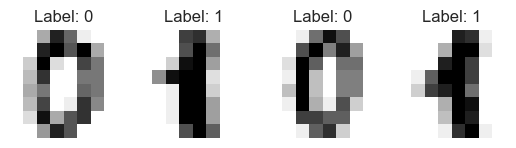

In [63]:
plot_examples()

In [64]:
# We can get a 2D version of the data using PCA
pca = PCA(n_components=2)
X = pca.fit_transform(digits.data) # this is the representation, we'll be working with
t = digits.target

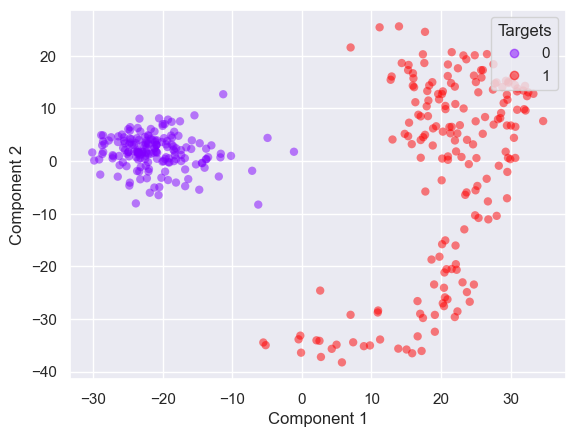

In [65]:
# Let's plot all the data in 2D
plot_scatter(X, t)

## 1) Fisher Discriminant Analysis (FDA)


### 1.1) Compute the class means (in PCA space)

Class means:
  Class 0: [-21.14447038   1.75335626]
  Class 1: [20.67975675 -1.71482096]


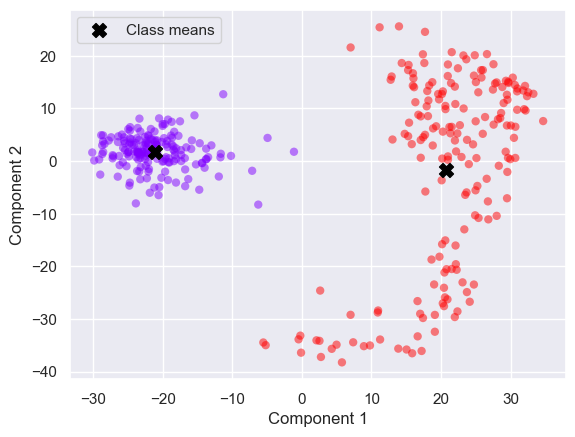

In [66]:
def class_means(X, t):
    classes = np.unique(t)
    means = []
    for c in classes:
        X_c = X[t == c]
        means.append(np.mean(X_c, axis=0))
    return np.array(means)

# Compute and print the class means
means = class_means(X, t)
print("Class means:")
for i, mean in enumerate(means):
    print(f"  Class {i}: {mean}")

# Plot the data with class means
plot_scatter(X, t, alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='black', s=100, marker='X', edgecolors='black', linewidths=1, label='Class means', zorder=5)
plt.legend()
plt.show()

### 1.2) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
Use eq (4.27) and (4.28) from textbook for computing $\mathbf{S}_B$ and $\mathbf{S}_W$ respectively

In [67]:
def scatter_mat_w(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_W = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        S_W += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

    return S_W

def scatter_mat_b(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    
    if len(classes) == 2:
        X_0 = X[t == classes[0]]
        X_1 = X[t == classes[1]]
        mean_0 = np.mean(X_0, axis=0)
        mean_1 = np.mean(X_1, axis=0)
        mean_diff = mean_1 - mean_0
        S_B = np.outer(mean_diff, mean_diff)

    return S_B

print("Sw:", scatter_mat_w(X, t))
print("")
print("Sb:", scatter_mat_b(X, t))

Sw: [[15041.33444706 13053.23317691]
 [13053.23317691 64127.63085988]]

Sb: [[1749.26597493 -145.05383207]
 [-145.05383207   12.02825328]]


### 1.3) Compute the projection vector $\mathbf{w}$
Hint: Use eq. (4.30) from textbook. You can use `np.linalg.pinv` and `np.linalg.eig` for computing the pseudo-inverse and eigenvectors, respectively. Also, remember to ensure that $||w||_2 = 1$

In [68]:
def compute_projection_vector(X, t):
    S_W = scatter_mat_w(X, t)
    S_B = scatter_mat_b(X, t)
    
    # inv(S_W) * S_B
    eigvals, eigvecs = scipy.linalg.eig(S_B, S_W)
    
    # Get the index of the largest eigenvalue
    max_index = np.argmax(eigvals.real)
    
    # Corresponding eigenvector
    w = eigvecs[:, max_index].real
    
    # Normalize the projection vector
    w /= np.linalg.norm(w)
    
    return w

Projection vector w: [-0.97678792  0.21420868]


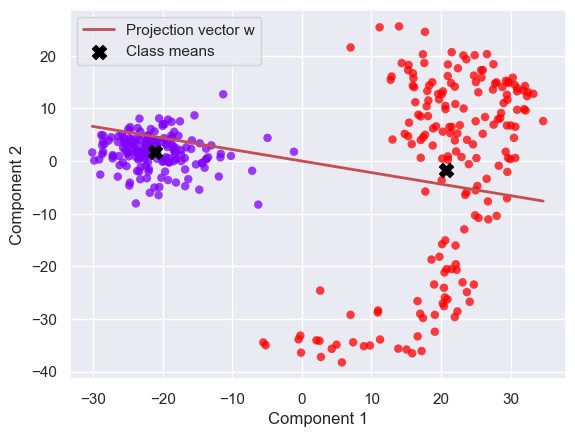

In [69]:
w = compute_projection_vector(X, t)
print("Projection vector w:", w)

plot_scatter(X, t, alpha=0.5)

origin = np.mean(X, axis=0)  

x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)

y_line = origin[1] + (w[1]/w[0]) * (x_range - origin[0])
plt.plot(x_range, y_line, 'r-', linewidth=2, label='Projection vector w')


plot_scatter(X, t, alpha=0.5)
plt.scatter(means[:, 0], means[:, 1], c='black', s=100, marker='X', edgecolors='black', linewidths=1, label='Class means', zorder=5)

plt.legend()
plt.show()

### 1.4) Compute and plot the 1D projection of the data
Hint: You can use `seaborn.displot` for a nice visualisation

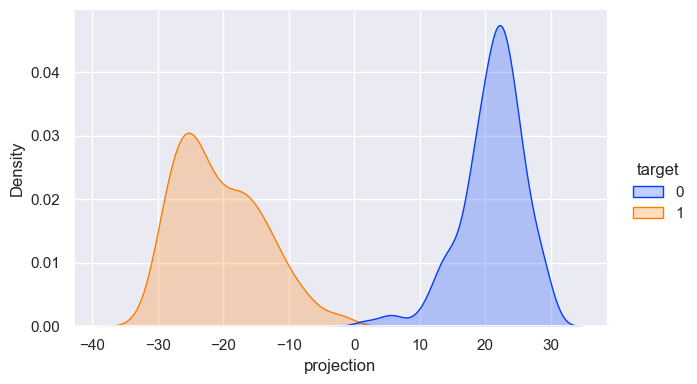

In [70]:
import pandas as p

w = compute_projection_vector(X, t)

proj = X.dot(w)

df_proj = pd.DataFrame({'projection': proj, 'target': t})

sns.displot(df_proj, x='projection', hue='target', kind='kde', height=4, aspect=1.6, fill=True)

plt.show()

### 1.5) Compute the class separation of the projected values

In [71]:
w = compute_projection_vector(X, t)
proj = X.dot(w)

means_proj = class_means(proj.reshape(-1, 1), t)

class_separation = abs(means_proj[1] - means_proj[0])[0]

print(f"Class separation: {class_separation}")

Class separation: 41.596313499803784


## 2) Linear Discriminant Analysis (LDA)

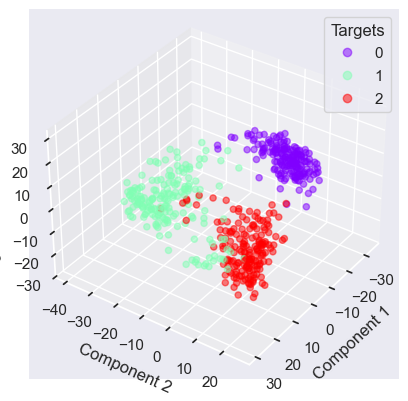

In [72]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
pca = PCA(n_components=3)
X = pca.fit_transform(digits.data)
t = digits.target

plot_scatter3d(X, t, view_point=(35,35))

### 2.1) Compute the within-class scatter matrix $\mathbf{S}_W$ and between-class scatter matrix $\mathbf{S}_B$
See section 4.1.6 in the textbook or Lecture 15 (slide 17)

In [73]:
def compute_scatter_mat_w(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_W = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        S_W += np.cov(X_c, rowvar=False) * (X_c.shape[0] - 1)

    return S_W

def compute_scatter_mat_b(X, t):
    n_features = X.shape[1]
    classes = np.unique(t)
    overall_mean = np.mean(X, axis=0)
    
    S_B = np.zeros((n_features, n_features))
    for c in classes:
        X_c = X[t == c]
        class_mean = np.mean(X_c, axis=0)
        n_c = X_c.shape[0]
        mean_diff = (class_mean - overall_mean).reshape(n_features, 1)
        S_B += n_c * (mean_diff).dot(mean_diff.T)

    return S_B

print("Sw:", compute_scatter_mat_w(X, t))
print("")
print("Sb:", compute_scatter_mat_b(X, t))

Sw: [[27768.47732317 19720.58431419 19025.65769928]
 [19720.58431419 51486.18362855 18774.45504116]
 [19025.65769928 18774.45504116 56959.24516861]]

Sb: [[168102.96379896 -19720.58431419 -19025.65769928]
 [-19720.58431419  63939.56120067 -18774.45504116]
 [-19025.65769928 -18774.45504116   9313.72193098]]


### 2.2) Compute the projection matrix $\mathbf{W}$
choose D'=2 (see lecture 15 slide 17 to understand D')

In [77]:
def compute_proj_mat_w(X, t):
    S_W = compute_scatter_mat_w(X, t)
    S_B = compute_scatter_mat_b(X, t)
    
    eigvals, eigvecs = scipy.linalg.eig(S_B, S_W)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigvals.real)[::-1]
    eigvals = eigvals[sorted_indices]
    eigvecs = eigvecs[:, sorted_indices]
    
    return eigvals, eigvecs

W = eigvecs[:, :2].real

print("Projection matrix W:")
print(W)
print()

Projection matrix W:
[[-0.91734684 -0.13270419]
 [ 0.33360306 -0.82474716]
 [ 0.21721826  0.54971058]]



### 2.3) Compute and plot the 2D projection of the data

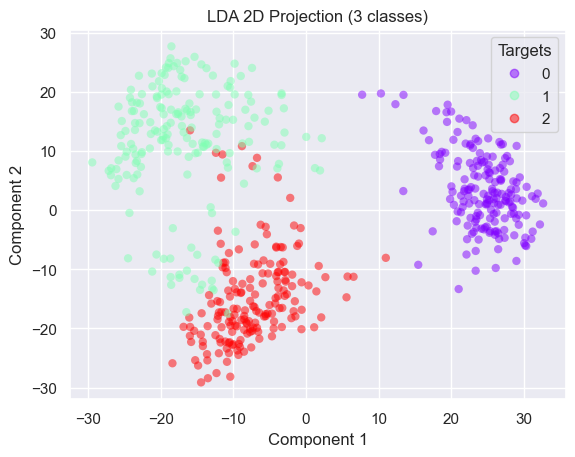

In [78]:
eigvals, eigvecs = compute_proj_mat_w(X, t)

X_projected = X @ W

plot_scatter(X_projected, t, alpha=0.5)
plt.title('LDA 2D Projection (3 classes)')
plt.show()

### 2.4) Compute and plot the 2D LDA projection of the original 64D data 

In [79]:
# Data
n_class = 3
digits = load_digits(n_class=n_class)
X = digits.data
t = digits.target

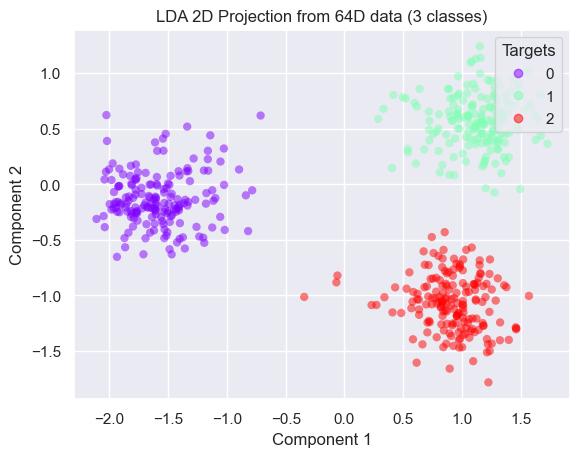

In [92]:
# Compute within class and between-class scatter matrices
S_W = compute_scatter_mat_w(X, t)
S_B = compute_scatter_mat_b(X, t)

# Add small regularization to avoid numerical issues
S_W_reg = S_W + 1e-6 * np.eye(S_W.shape[0])

# Compute eigenvalues and eigenvectors, sort them and select top 2 eigenvectors
eigvals, eigvecs = scipy.linalg.eig(S_B, S_W_reg)

# Sort eigenvalues and eigenvectors by real part in descending order
sorted_indices = np.argsort(eigvals.real)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

# Select top 2 eigenvectors for projection matrix W
W = eigvecs[:, :2].real

# Normalize each eigenvector
W[:, 0] = W[:, 0] / np.linalg.norm(W[:, 0])
W[:, 1] = W[:, 1] / np.linalg.norm(W[:, 1])

# Perform projection from 64D to 2D
X_projected = X @ W

# Plot projection in 2D using the same style as other plots
plot_scatter(X_projected, t, alpha=0.5)
plt.title('LDA 2D Projection from 64D data (3 classes)')
plt.show()


Comment on the general utility of the projection as compared to PCA

# 3) Constrained Optimization
 
Consider the problem

minimize $f_{min}(x_1, x_2)$

subject to $ x_1 + x_2 \leq 4 
\quad \text{ and } \quad x_1 + 4x_2 = 5 
$
where $f_{min}(x_1, x_2) = (x_1 - 3)^2 + (x_2 - 2)^2$

## 3.1) Reformulate the problem as a canonical maximization problem
_Use the form described in the end of "Pattern Recognition and Machine Learning" Appendix E._

_NB: There is an error in appendix E: $h(x) \leq 0$, not $h(x) \geq 0$._

## 3.2) Write out the Lagrangian function
_Use Equation (E.12) in "Pattern Recognition and Machine Learning" Appendix E., and write out all variables_

## 3.3) Compute the gradients with respects to $x_1, x_2$, lagrange multiplier $\lambda$ and the KKT multiplier $\mu$

### 3.4) Compute the optimum
_Hint: Set it up as a system of linear equations and solve it using Gaussian Elimination (e.g. using `scipy.linalg.solve`)._

Follow these steps:

1. **Assume the inequality constraint \( h(x) \) is inactive.**  
   - Set its Lagrange multiplier to zero (\( \mu = 0 \)).  
   - Include only the equality constraint \( g(x) = 0 \) in your formulation.  
   - Construct the system of equations from the KKT conditions:  
     \[
     \nabla f(x) + \lambda \nabla g(x) = 0, \quad g(x) = 0
     \]
   - Solve for \( x_1, x_2, \lambda \) using `scipy.linalg.solve`.

2. **Check the inequality constraint.**  
   - Evaluate \( h(x_1, x_2) \).  
   - If \( h(x_1, x_2) < 0 \), the constraint is inactive — keep this as your final solution.

3. **If the inequality is violated** (\( h(x_1, x_2) > 0 \)):  
   - Reformulate the problem assuming \( h(x) \) is **active** (\( h(x) = 0 \)).  
   - Include both constraints in the Lagrangian:  
     \[
     \mathcal{L}(x_1, x_2, \lambda, \mu) = f(x_1, x_2) + \lambda g(x_1, x_2) + \mu h(x_1, x_2)
     \]
   - Construct the corresponding system of equations:
     \[
     \nabla f(x) + \lambda \nabla g(x) + \mu \nabla h(x) = 0, \quad g(x) = 0, \quad h(x) = 0
     \]
   - Solve for \( x_1, x_2, \lambda, \mu \) using `scipy.linalg.solve`.

_The correct optimum is the solution that satisfies all constraints and yields the lowest \( f(x) \)._


In [93]:
# Your code here

STEP 1: Assume inequality constraint is INACTIVE (μ = 0)

Solution with μ = 0:
  x1 = 2.647059
  x2 = 0.588235
  λ  = -0.705882
  f(x1, x2) = 2.117647

Checking inequality constraint h(x) = x1 + x2 - 4:
  h(x) = -0.764706
  ✓ Constraint satisfied (h(x) ≤ 0). Inequality is INACTIVE.

FINAL SOLUTION (inequality inactive):
  x1* = 2.647059
  x2* = 0.588235
  Optimal value: f(x*) = 2.117647

